In [1]:
## import VGG16 pretrained model
from tensorflow.keras.applications import VGG16

In [2]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
import mimetypes
import argparse
import imutils
import os

In [3]:
## define the path of train images which is all image is in training_images folder
IMAGES_PATH = os.path.sep.join(['./data/training_images'])

# Define the path to the CSV file containing annotations for bounding boxes
ANNOTS_PATH = os.path.sep.join(['./data/train_solution_bounding_boxes (1).csv'])

In [4]:
# This variable holds the base directory path where all the output files will be saved.
BASE_OUTPUT = 'output'

# Create the base output directory if it doesn't exist
os.makedirs(BASE_OUTPUT, exist_ok=True)

# Define the path to save the trained model

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, 'detector.h5'])

# define the path to save the plot of training history
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, 'plot.png'])

# Define the path to save the list of test filenames
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, 'test_images.txt'])

### Loading dataset


In [5]:
rows = open(ANNOTS_PATH).read().strip().split('\n')

data = []
targets = []
filenames = []

In [6]:
rows[:5]

['image,xmin,ymin,xmax,ymax',
 'vid_4_1000.jpg,281.2590449,187.0350708,327.7279305,223.225547',
 'vid_4_10000.jpg,15.16353111,187.0350708,120.3299566,236.4301802',
 'vid_4_10040.jpg,239.1924747,176.7648005,361.9681621,236.4301802',
 'vid_4_10020.jpg,496.4833575,172.3632561,630.0202605,231.5395753']

In [7]:
## Loop over the rows
for row in rows[1:]:
    row = row.split(",")
    # split the row into individual values
    (filename, startX, startY, endX, endY) = row
    # construct the path to the image
    imagePath = os.path.join(IMAGES_PATH, filename)
    # read the image using opencv
    image = cv2.imread(imagePath)
    # get the height and weight of image
    (h, w) = image.shape[:2]
    
    # Normalize the bounding box coordinates
    startX = float(startX) / w
    startY = float(startY) / h
    
    endX = float(endX) / w
    endY = float(endY) / h
    
    # load and preprocess the image using keras
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    # Append the preprocessed image, target coordinates, and filename to their respective lists
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

# Split the dataset

In [8]:
data = np.array(data, dtype = 'float32') / 255.0

targets = np.array(targets, dtype = 'float32')

split = train_test_split(data, targets, filenames, test_size = 0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

with open(TEST_FILENAMES, 'w') as f:
    f.write('\n'.join(testFilenames))

## building model

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, BatchNormalization

In [10]:
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

vgg.trainable = False

flatten = vgg.output

flatten = Flatten()(flatten)


# Add fully connected layers for bounding box regression
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)

In [11]:
# Initialize the learning rate
INIT_LR = 1e-4

# Define the number of epochs for training
NUM_EPOCHS = 25

# Define the batch size for training
BATCH_SIZE = 32

In [12]:
opt = Adam(learning_rate=INIT_LR)

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])

In [13]:
# Train the model on the training data with validation on the testing data
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    shuffle=True,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)

Epoch 1/25
16/16 [==============================] - 40s 2s/step - loss: 0.0500 - accuracy: 0.5924 - val_loss: 0.0458 - val_accuracy: 0.5000
Epoch 2/25
16/16 [==============================] - 6s 392ms/step - loss: 0.0429 - accuracy: 0.6382 - val_loss: 0.0476 - val_accuracy: 0.5000
Epoch 3/25
16/16 [==============================] - 6s 393ms/step - loss: 0.0376 - accuracy: 0.6779 - val_loss: 0.0438 - val_accuracy: 0.5893
Epoch 4/25
16/16 [==============================] - 6s 393ms/step - loss: 0.0328 - accuracy: 0.7475 - val_loss: 0.0396 - val_accuracy: 0.5714
Epoch 5/25
16/16 [==============================] - 6s 395ms/step - loss: 0.0305 - accuracy: 0.7773 - val_loss: 0.0397 - val_accuracy: 0.6250
Epoch 6/25
16/16 [==============================] - 6s 394ms/step - loss: 0.0292 - accuracy: 0.7674 - val_loss: 0.0399 - val_accuracy: 0.6071
Epoch 7/25
16/16 [==============================] - 6s 394ms/step - loss: 0.0283 - accuracy: 0.7714 - val_loss: 0.0376 - val_accuracy: 0.6964
Epoch 8/

In [14]:
#saving object detector model
model.save(MODEL_PATH, save_format="h5")

### Plot the training and validation loss over epochs

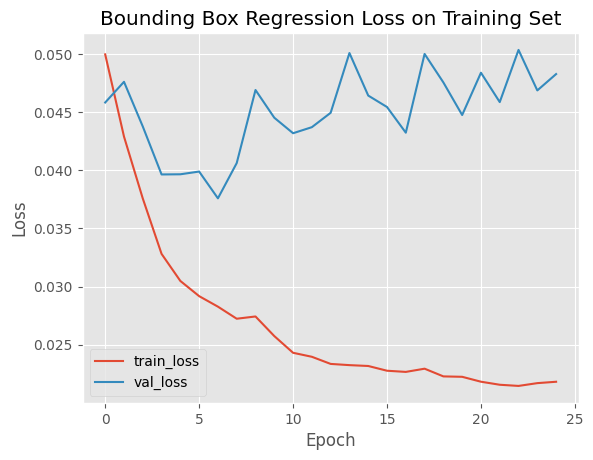

In [15]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [16]:
#loading object detector
model = load_model(MODEL_PATH)

1/1 [==============================] - 2s 2s/step


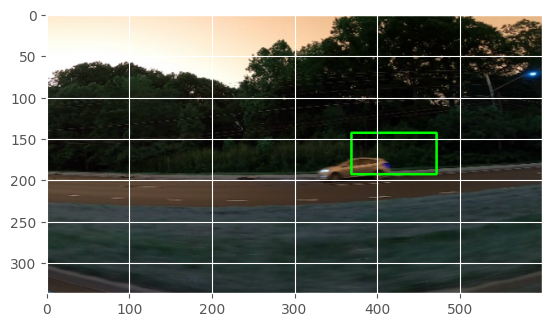

In [19]:
# Define the path to the testing image
imagePath = "./data/testing_images/vid_5_29460.jpg"

# Load and preprocess the testing image
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make predictions using the trained model
preds = model.predict(image)[0]

# Extract predicted bounding box coordinates
(startX, startY, endX, endY) = preds

# Read the original image and resize it
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Scale the predicted coordinates to match the resized image
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Draw the bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Display the image with the bounding box
plt.imshow(image)